# Hidden Markov Model (HMM)

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath('..'))


from datasets.em_gaussian import EMGaussianDataset
from src.utils.plot import plot_clusters, plot_ellipses
from src.hidden_markov_model import HiddenMarkovModel
from src.gaussian_mixture_model import GaussianMixtureModel

import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
x_train = EMGaussianDataset("../datasets/data/EMGaussian",train=True)[0]
x_test = EMGaussianDataset("../datasets/data/EMGaussian",train=False)[0]

hmm.pi
 [1.00000000e+00 4.59374844e-30 2.25523350e-71 1.10161030e-19]
hmm.transition_matrix
 [[0.89479957 0.03463008 0.03238552 0.06301042]
 [0.01986561 0.88601582 0.01265622 0.03991466]
 [0.07242174 0.04862918 0.02261366 0.88109661]
 [0.00678685 0.03937658 0.92645892 0.0157638 ]]
hmm.means
 [[-2.97260218 -3.44958265]
 [ 3.78946943 -3.99313579]
 [ 3.99372552  3.59101573]
 [-1.94809661  4.19443791]]
hmm.covariances
 [[[ 6.78104434  6.55761432]
  [ 6.55761432  6.65919716]]

 [[ 0.95270364  0.06496194]
  [ 0.06496194  1.52437352]]

 [[ 0.1977791   0.26502014]
  [ 0.26502014 12.51310604]]

 [[ 3.2932424   0.30313762]
  [ 0.30313762  2.82801451]]]


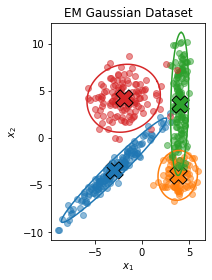

In [3]:
hmm = HiddenMarkovModel(k=4, seed=10)
hmm.initialize(x_train)
likelihoods_train, likelihoods_test = hmm.train(x_train, x_test, likelihood = True)
print("hmm.pi\n", torch.exp(hmm.pi_log).numpy())
print("hmm.transition_matrix\n", torch.exp(hmm.transition_matrix_log).numpy())
print("hmm.means\n", hmm.emission_distribution.means.numpy())
print("hmm.covariances\n", hmm.emission_distribution.covariances.numpy())

plot_ellipses(hmm.emission_distribution)
hmm.emission_distribution.predict = lambda _: hmm.predict(x_train)
plot_clusters(hmm.emission_distribution, x_train)
plt.show()

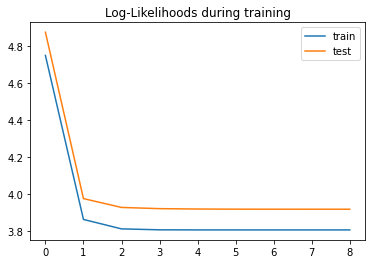

In [4]:
plt.plot(likelihoods_train, label="train")
plt.plot(likelihoods_test, label="test")
plt.legend(loc="best")
plt.title("Log-Likelihoods during training")
plt.show()

In [5]:
from src.distributions import GaussianDistribution

def get_error(models):
    data=[]
    for model_name, model in models.items():
        model.initialize(x_train)
        model.train(x_train)
        data.append([model.normalized_negative_marginal_log_likelihood(x_train).item(),
                     model.normalized_negative_marginal_log_likelihood(x_test).item()])
    row_names = [m for m in models]
    column_names=["train", "test"]
    return data, row_names, column_names


models = {
    "gmm_isotropic": GaussianMixtureModel(4, covariance_type="isotropic"),
    "gmm_full":  GaussianMixtureModel(4),
    "hmm_gmm_isotropic": HiddenMarkovModel(k=4, emission_distribution_type=lambda k,d: GaussianDistribution(k,d, covariance_type='isotropic')),
    "hmm_gmm_full": HiddenMarkovModel(k=4)
}
data, row_names, column_names = get_error(models)
pd.DataFrame(data, index=row_names, columns=column_names).round(2)

,train,test
gmm_isotropic,5.30,5.34
gmm_full,4.66,4.82
hmm_gmm_isotropic,4.66,4.52
hmm_gmm_full,3.83,3.90
